# Crime and Neural Nets
## RNN, LSTM, GRU

Carolin Kunze <br>
Marc Scheu <br>
Thomas Siskos <br>

Our code lives on [Github](https://github.com/thsis/INFOSYS)

## Outline

- Chicago Crime Data
- Why do we need Recurrent Neural Networks?
- Introduction to RNNs
- Long Short Term Memory Cell **(LSTM)**
- Gated Recurrent Unit **(GRU)**
- Implementation of RNN, LSTM and GRU
- Parameter Tuning and Evaluation

In [1]:
import os
import json
import sys

import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from ipywidgets import interactive

from keras.layers import SimpleRNN, LSTM, GRU
from models.recurrent import Recurrent

from sklearn.metrics import mean_squared_error
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

%matplotlib inline

Using TensorFlow backend.


In [2]:
datapath = os.path.join("data", "crimes.zip")
columns = ["ID", "Date", "Block", "Primary Type", "Latitude", "Longitude", "District", "Ward", "Community Area"]
fulldata = pd.read_csv(datapath, usecols=columns)

In [3]:
fulldata["Date"] = pd.to_datetime(fulldata["Date"],
                                  format='%m/%d/%Y',
                                  exact=False)
fulldata = fulldata.set_index("Date")

## Chicago Crime Data

Where should the head of the Chicago Police Force sent his patrols?

In [4]:
fulldata.head(10)

,ID,Block,Primary Type,District,Ward,Community Area,Latitude,Longitude
Date,,,,,,,,
2015-03-18,10000092,047XX W OHIO ST,BATTERY,11.0,28.0,25.0,41.891399,-87.744385
2015-03-18,10000094,066XX S MARSHFIELD AVE,OTHER OFFENSE,7.0,15.0,67.0,41.773372,-87.665319
2015-03-18,10000095,044XX S LAKE PARK AVE,BATTERY,2.0,4.0,39.0,41.813861,-87.596643
2015-03-18,10000096,051XX S MICHIGAN AVE,BATTERY,2.0,3.0,40.0,41.800802,-87.622619
2015-03-18,10000097,047XX W ADAMS ST,ROBBERY,11.0,28.0,25.0,41.878065,-87.743354
2015-03-18,10000098,049XX S DREXEL BLVD,BATTERY,2.0,4.0,39.0,41.805443,-87.604284
2015-03-18,10000099,070XX S MORGAN ST,BATTERY,7.0,17.0,68.0,41.766403,-87.649296
2015-03-18,10000100,042XX S PRAIRIE AVE,BATTERY,2.0,3.0,38.0,41.817553,-87.619819
2015-03-18,10000101,036XX S WOLCOTT AVE,NARCOTICS,9.0,11.0,59.0,41.828138,-87.672782


In [5]:
primary_types = ['TOTAL'] + fulldata["Primary Type"].unique().tolist()

In [6]:
def crime_viewer(crime="TOTAL", year=2001):
    crime_type = crime.lower().replace(" ", "_")
    png_title = "crime_" + crime_type + "_" + str(year) + ".png"
    plt.figure(figsize=(15, 6))
    img = mpimg.imread(os.path.join("preprocessing", "maps", png_title))
    plt.imshow(img, aspect="auto")
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    

## Chicago Crime Data

Are there geographical patterns?

In [7]:
interactive(crime_viewer, crime = primary_types, year=(2001, 2017, 1))

interactive(children=(Dropdown(description='crime', options=('TOTAL', 'BATTERY', 'OTHER OFFENSE', 'ROBBERY', '…

## Why do we need Recurrent Neural Networks? 

### Recap Feed Forward Network
<img src="presentation/presentation_pics/neural_network1.png" alt="NN" style="width: 400px;"/>
[Source:  Alisa's Presentation on NN Primer]

## Lets simplify

<img src="presentation/presentation_pics/NN_simplified.png" alt="NN" style="width: 500px;"/>

### Input data:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; __“In France, I had a great time”__

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)


- Changed from color to shape coding 
- got rid of dimensionality --> eachs symbol represents multiple activations
- each arrow represents a Layer operation e.g. a matrix multiplication
<br>
<br>
- Theory on Textanalysis example, bc intuitve understanding of sequential dependencies in Language

## Use Case sentiment analysis
### Is this a __positive__ or a __negative__ statement?

__“In France, I had a great time”__

<img src="presentation/presentation_pics/NN_simplified.png" alt="NN" style="height: 250px"/>

__One Solution:__

- Turn sentence into vector (Bag-of-Words)
- Use NN to predict the sentiment for each sentence independently

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)

#### One Solution:
- Use Bag-of_words to transfer sentence into a vector (Order doesnt matter)
- Use a Feed Forward Network to predict the class of the given sentence

<br>

#### Notice:
- The order of the words is not taken into account
- Each sentence / document is a single observation
- The classification of the next sentencen is independent from the last sentence



## Let's change our classification task:

### What will be the next word?
__“In France, I had a great ...?”__

<img src="presentation/presentation_pics/NN_simplified.png" alt="NN" style="width: 500px;"/>


__How can we include multiple observation vectors while preserving the order?__

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)

#### Whats new:
- Each word is an observation at a given point of time
- The next word depends mainly on the previous words -> the order is important
- Each word might be represented as a vector 
<br>

## How to add annother preceding timestep

### What will be the next word?

__“a great ...?”__

<img src="presentation/presentation_pics/RNN2.png" alt="NN" style="width: 600px;"/>

Prediction at time t:  $$y_t = softmax(W_{out}h_t)$$
Activations for step t: $$h_t = tanh(W_{in}x_t + W_hh_{t-1})$$

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)



W_in, W_h, W_out are equal across all steps --> reduces the number of parameters to learn
http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/

## How to add annother preceding timestep

### What will be the next word?


__“had a great ...?”__

<img src="presentation/presentation_pics/RNN3.png" alt="NN" style="width: 650px;"/>

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)




## Adding an abitrary number of preceding words

### What will be the next word?
__“In France, I had a great ...?”__

<img src="presentation/presentation_pics/RNN_loop.png" alt="NN" style="width: 600px;"/>

[Source: fast.ai](https://course.fast.ai/lessons/lesson6.html)

## How to train a Recurrent Neural Net

### Backpropagation through time (bptt)


Total Loss: $$J(\theta) = \sum_t{J_t(\theta)}$$
Loss at time t: $$J_t(\theta) = f(y_{t,true}, y_{t})$$


Gradient: $$\frac{\partial J_t}{\partial W_{in}} =
\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial W_{in}} = 
\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial h_{t}}\frac{\partial h_t}{\partial W_{in}}=
\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial h_{t}}\frac{\partial h_t}{\partial h_{t-1}}
\frac{\partial h_{t-1}}{\partial W_{in}} = 
\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial h_{t}}\frac{\partial h_t}{\partial h_{t-1}}
\frac{\partial h_{t-1}}{\partial h_{t-2}} ...\frac{\partial h_{0}}{\partial W_{in}}
$$




<img src="presentation/presentation_pics/RNN_loop.png" alt="NN" style="width: 600px;"/>

Sources:
* [introtodeeplearning.com](http://introtodeeplearning.com/materials/2018_6S191_Lecture2.pdf)
* [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com/chap5.html)

## Drawback of a simple Recurrent Network


### Forgetting long-term dependencies:

__“In France, I had a great time and I learnt some of the ...? [language]"__ 
 
<img src="presentation/presentation_pics/vanishing_gradient.png" alt="vanishing_gradient" style="width: 600px;"/>

[Source: C. Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)



- cannot connect information anymore
- "vanishing gradient problem"

# Vanishing Gradient problem

Gradient: $$\frac{\partial J_t}{\partial W_{in}} =\frac{\partial J_t}{\partial y_{t}}\frac{\partial y_t}{\partial h_{t}}\frac{\partial h_t}{\partial h_{t-1}}
\frac{\partial h_{t-1}}{\partial h_{t-2}} ...\frac{\partial h_{0}}{\partial W_{in}}$$
<br><br>
It can be shown: $$\frac{\partial h_t}{\partial h_{t-1}}
= W_{in}^T diag[tanh^{ `}(W_{in}+W_h x_j)]$$
<br>
$tanh^{ `} \in [0,1] $ <br><br>
$W_{in}$ = sampled from standard normal distribution = mostly < 1
<br>
<br>
Sources
* [introtodeeplearning.com](http://introtodeeplearning.com/materials/2018_6S191_Lecture2.pdf)
* [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com/chap5.html)

- backpropagation through time
- as gap between timesteps becomes bigger, product longer and we are multiplying very small numbers (small gradients)
- due to activation function (tanh)
- some crucial previous timesteps do not influence anymore in later timesteps: gradient vanishes...

# Advanced RNNs: LSTM and GRU

<img src="https://cdn-images-1.medium.com/max/600/1*z380CENiF6G5NcQuXrw-hw.png" alt="LSTM" style="width: 1000px;"/>

[Source: towardsdatascience.com](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464)

# LSTM Network - Long Short-Term Memory Network

# LSTM
<img src="presentation/presentation_pics/LSTM.png" alt="LSTM" style="width: 1000px;"/>

[Source: C. Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

# LSTM - Cell State and Hidden State

<img src="presentation/presentation_pics/lstm_core_idea.png" alt="LSTM" style="width: 600px;"/>




# LSTM - 1.) Forget Gate

<img src="presentation/presentation_pics/lstm_forget.png" alt="LSTM" style="width: 800px;"/>

# "A man has dinner with his wife and her parents." 

# LSTM - 2.) Input Gate

<img src="presentation/presentation_pics/lstm_input.png" alt="LSTM" style="width: 800px;"/>

# "A man has dinner with his wife and her parents." 

# LSTM - 3.) New Cell State

<img src="presentation/presentation_pics/lstm_new_cell_state.png" alt="LSTM" style="width: 800px;"/>

# "A man has dinner with his wife and her parents." 

# LSTM - 4.) Output Gate

<img src="presentation/presentation_pics/lstm_output.png" alt="LSTM" style="width: 800px;"/>

# "A man has dinner with his wife and her parents." 

# LSTM Take Away
1. forget
2. update 
3. output 


# Why LSTM?
- forget gate can let information pass through unchanged 
- cell state separate from output
## “In France, I had a great time and I learnt some of the French language.”


- cell states depend through addition: prevent vanishing gradient

[Source: H. Suresh](http://harinisuresh.com/2016/10/09/lstms/)



## GRU Network - Gated Recurrent Unit##

## GRU
<img src="presentation/presentation_pics/GRU.png" alt="GRU" style="width: 800px;"/>

simplified example:
- 1. values of update gate z_t = 0 : ignore current state

\begin{align}
\mathbf{h_t = 1*h_{t-1} + 0*h_t}
\end{align}

- 2. values of update gate z_t = 1 : ignore previous state

\begin{align}
\mathbf{h_t = 0*h_{t-1} + 1*h_t} 
\end{align}



[Source: C. Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [8]:
datapath = os.path.join("data", "crimes_district.csv")
dataset = pd.read_csv(datapath, index_col=["Date", "District"],
                      dtype={"crimes_district_total": np.float32},
                      parse_dates=["Date"])

## Implementation

### The `Recurrent` class

* Convenient interface for all our models

Epoch 1/1
125016/125016 [==============================] - 371s 3ms/step - loss: 0.0137


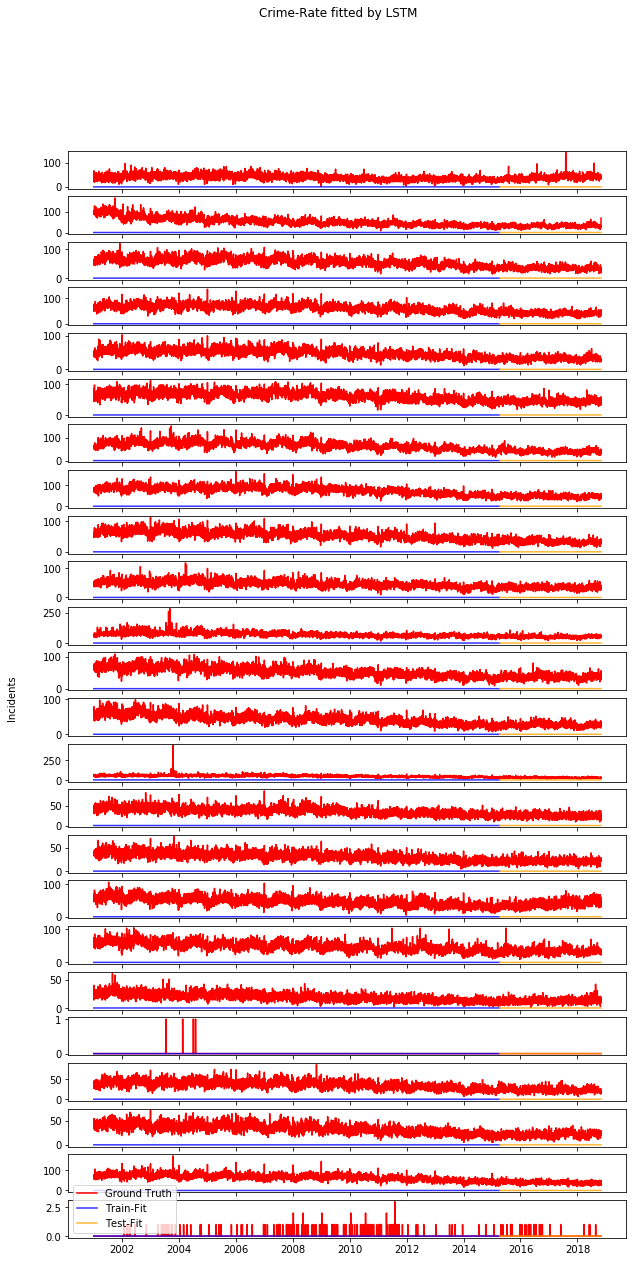

In [9]:
lstm = Recurrent(dataset, 2, cell=LSTM, epochs=1)
lstm.train()
fig, ax = lstm.plot_fit(os.path.join("models", "lstm-district-show-case.png"),
                        figsize=(10, 20))


The life-cycle consists of:
1. instantiation
2. training
3. prediction
3. visual analysis

### 1. \_\_init\_\_

* prepare all necessary attributes in `__stage()`
* call


```python
class Recurrent(Sequential):
    def __init__(...):
        # save attributes
        ...
        self.X_train, self.X_test, self.y_train, self.y_test = self.__stage()
        # run parent-class' constructor
        super().__init__()
```

#### 1.1 __stage()

* scale

```python
def __stage(self):
    # Separate train and test data
    ...
    
    self.scaler = MinMaxScaler()
    self.scaler.fit(train.values)
    self.data.loc[:, "y"] = self.scaler.transform(self.data.values)
    ...
    X, y = self.__get_features()
```

#### 1.1.1 \_\_get_features()

* construct features

```python
def __get_features(self):
        """
        Create lagged variables in `self.data`.

        * Returns:
            * (X, y): `numpy.ndarray`s of feature and target values.
        """
        cols = ["lag_" + str(i) for i in range(1, self.maxlag+1)]

        for i, colname in enumerate(cols, 1):
            if isinstance(self.data.index, pd.core.index.MultiIndex):
                lag = self.data.groupby(self.cross_label)["y"].shift(i)
            else:
                lag = self.data["y"].shift(i)

            self.data[colname] = lag

        self.data = self.data.dropna(axis=0)

        # Split into target and features
        y = self.data.iloc[:, 1]
        X = self.data.iloc[:, 2:]

        return X, y
```

### 2. train()

```python
def train(self):
    self.add(self.cell(self.cell_neurons,
                           input_shape=(1, self.maxlag),
                           **self.cellkwargs))
    self.add(Dense(1))
    self.add(Activation('relu'))

    self.compile(loss=self.lossfunc,
                 optimizer=self.optimizer)
    self.fit(X_train, self.y_train,
             epochs=self.epochs,
             batch_size=self.batch_size,
             verbose=self.verbose,
             **self.fitkwargs)
```

### 3. forecast()

* predict test data or completely new data.

```python
def forecast(self, X):
        if X.shape[1] == self.maxlag:
            X_ = self.__transform_shape(X)
            return self.predict(X_)

        else:
            X_, _ = self.__get_features(X)
            return self.predict(X_.values)
```

## Parameter Tuning with `hyperopt`

### Back to the crime dataset

We look at two distinct questions:
1. Can we accurately predict the development of the **whole** time series for the city of Chicago?
2. Can we accurately predict the development of the series for **each district**?

#### 1. Load the full series:

The full series contains a single column of summed up incidents per day. We also parse the dates inside the `date` column and set them as the index of the `DataFrame`.

In [10]:
datapath_whole = os.path.join("data", "crime_total.csv")
whole = pd.read_csv(datapath_whole, index_col=["date"],
                    dtype={"crimes_total": np.float32},
                    parse_dates=["date"])
whole.head()

,crimes_total
date,
2001-01-01,1814.0
2001-01-02,1143.0
2001-01-03,1151.0
2001-01-04,1166.0
2001-01-05,1267.0


#### 2. Load the series by district:

Here we also parse the dates inside the `Date` column and specify a `MultiIndex` where the levels are `Date` and then `District`. This allows our `models.recurrent`-class to distinguish between the series for the whole of Chicago and the Chicago crime series by each district.

In [11]:
datapath_district = os.path.join("data", "crimes_district.csv")
district = pd.read_csv(datapath_district, index_col=["Date", "District"],
                       dtype={"District": object,
                              "Incidents": np.float32},
                       parse_dates=["Date"])
district.sort_index().head(24).T

Date      2001-01-01                                                      \
District        1.0    2.0    3.0   4.0   5.0   6.0   7.0    8.0    9.0    
Incidents       37.0  110.0  103.0  96.0  95.0  84.0  83.0  111.0  109.0   

Date             ...                                                         \
District    10.0 ...   16.0  17.0  18.0  19.0  20.0 21.0  22.0  24.0   25.0   
Incidents  104.0 ...   67.0  67.0  72.0  72.0  40.0  0.0  61.0  59.0  120.0   

Date            
District  31.0  
Incidents  0.0  

[1 rows x 24 columns]

### Separate data and a holdout set.

* We use an algorithm that uses the test set.
* Danger of overfitting.
* so we separate a holdout set.

In [12]:
cutoff = pd.to_datetime("2018-10-01")
whole_data = whole.loc[whole.index < cutoff]
whole_holdout = whole.loc[whole.index >= cutoff]

# As always with MultiIndices, things are a little more complicated.
district_data = district.loc[district.index.map(lambda x: x[0] < cutoff)]
district_holdout = district.loc[district.index.map(lambda x: x[0] > cutoff)]

### Define a parameter space

* choose a prior distribution from which parameters are sampled.
* we choose mostly from the uniform distribution.

In [13]:
# add optimizer, learn-rate, 
paramspace = {"maxlag": scope.int(hp.quniform("maxlag", 1, 3, 1)),
              "cell_neurons": scope.int(hp.quniform("cell_neurons", 1, 30, 1)),
              "batch_size": scope.int(hp.quniform("batch_size", 1, 10, 1)),
              "optimizer": hp.choice("optimizer", ["adam", "sgd"])}

* and create one dictionary for each cell we want to use. 

In [14]:
spacesdict ={}
for cell in (SimpleRNN, LSTM, GRU):
    spacesdict[cell.__name__] = {"cell": cell, **paramspace}

pprint(spacesdict)

{'GRU': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f05a7412748>,
         'cell': <class 'keras.layers.recurrent.GRU'>,
         'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f059ab9cb70>,
         'maxlag': <hyperopt.pyll.base.Apply object at 0x7f059ab9cc88>,
         'optimizer': <hyperopt.pyll.base.Apply object at 0x7f05a7412da0>},
 'LSTM': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f05a7412748>,
          'cell': <class 'keras.layers.recurrent.LSTM'>,
          'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f059ab9cb70>,
          'maxlag': <hyperopt.pyll.base.Apply object at 0x7f059ab9cc88>,
          'optimizer': <hyperopt.pyll.base.Apply object at 0x7f05a7412da0>},
 'SimpleRNN': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f05a7412748>,
               'cell': <class 'keras.layers.recurrent.SimpleRNN'>,
               'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f059ab9cb70>,
               'maxlag': <hyperopt.pyll.base.Ap

### Set up `Trials`-object to store the results

* We can later visualize the search process.
* Based on that, we can make decisions if we want to keep the parameters or not.

In [15]:
trialsdict = {key: {model: Trials() for model in ("SimpleRNN", "LSTM", "GRU")} for key in ("whole", "district")}
pprint(trialsdict)

{'district': {'GRU': <hyperopt.base.Trials object at 0x7f05acb037b8>,
              'LSTM': <hyperopt.base.Trials object at 0x7f05acb03208>,
              'SimpleRNN': <hyperopt.base.Trials object at 0x7f05acb03358>},
 'whole': {'GRU': <hyperopt.base.Trials object at 0x7f05acb03400>,
           'LSTM': <hyperopt.base.Trials object at 0x7f05acb03940>,
           'SimpleRNN': <hyperopt.base.Trials object at 0x7f05acb03cf8>}}


### Optimizing over the parameter space

* We first define an objective function.
* Then we pass it to the `fmin`-routine.

* With 3 model classes and 2 different datasets we would need 6 of those.
* So we do something different - we use `Python`s decorator syntax.

In [16]:
def minimizer(objective):
    def outer(paramspace, trials, max_evals=3):
        pbar = tqdm(total=max_evals, desc=paramspace["cell"].__name__)
        def inner(*args, **kwargs):
            pbar.update()
            return objective(*args, **kwargs)

        best = fmin(fn=inner,
                    space=paramspace,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        pbar.close()
        return best
    return outer

And now to the function we wish to decorate. It contains 3 steps:
1. Create a model with a certain set of (yet undefined) parameters.
2. Train the model.
3. Calculate the loss on a test set and return a dictionary, that contains the loss and a flag indicating that everything went okay.

We do this for the whole series:

In [17]:
@minimizer
def whole_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(whole_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

And for the series by district:

In [18]:
@minimizer
def district_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(district_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

In [19]:
import time
@minimizer
def district_get_loss(params):
    time.sleep(1)
    return {"loss": np.random.uniform(), "status": STATUS_OK}
@minimizer
def whole_get_loss(params):
    time.sleep(2)
    return {"loss": np.random.uniform(), "status": STATUS_OK}

### Tune the parameters

* We pass through all our models 
* for each dataset and finally
* store the best hyperparameters in a dictionary.

In [20]:
models = ("SimpleRNN", "LSTM", "GRU")
best = {"whole": {},
        "district": {}}

for model in models:
    best["whole"][model] = whole_get_loss(spacesdict[model], 
                                          trialsdict["whole"][model])
    best["district"][model] = district_get_loss(spacesdict[model],
                                                trialsdict["district"][model])

In [21]:
with open("analysis/best_params.json") as file:
    best = json.load(file)

In [22]:
pprint(best)

{'district': {'GRU': {'batch_size': 4.0,
                      'cell_neurons': 28.0,
                      'maxlag': 44.0,
                      'optimizer': 0},
              'LSTM': {'batch_size': 1.0,
                       'cell_neurons': 8.0,
                       'maxlag': 50.0,
                       'optimizer': 0},
              'SimpleRNN': {'batch_size': 4.0,
                            'cell_neurons': 7.0,
                            'maxlag': 42.0,
                            'optimizer': 0}},
 'whole': {'GRU': {'batch_size': 1.0,
                   'cell_neurons': 22.0,
                   'maxlag': 26.0,
                   'optimizer': 0},
           'LSTM': {'batch_size': 1.0,
                    'cell_neurons': 19.0,
                    'maxlag': 23.0,
                    'optimizer': 0},
           'SimpleRNN': {'batch_size': 1.0,
                         'cell_neurons': 27.0,
                         'maxlag': 14.0,
                         'optimizer': 0}}}


## Visualize the search Process

First for the districts:

<img src="analysis/figures/district-hyperopt-SimpleRNN.png">

<img src="analysis/figures/district-hyperopt-LSTM.png">

<img src="analysis/figures/district-hyperopt-GRU.png">

And for the whole series:

<img src="analysis/figures/whole-hyperopt-SimpleRNN.png">

<img src="analysis/figures/whole-hyperopt-LSTM.png">

<img src="analysis/figures/whole-hyperopt-GRU.png">

In [23]:
def typecast(params):
    out = {}
    optimizers = ["adam", "sgd"]
    for key, val in params.items():
        if key == "optimizer":
            out[key] = optimizers[val]
        else:
            try:
                out[key] = int(val)
            except TypeError:
                out[key] = val
    return out

### Evaluate the obtained Hyperparameters 

* We can compute the proportion of observations before our cutoff point
* and use the remainder for the new test set.

In [24]:
train_size = whole.index.get_loc(cutoff) /len(whole.index.unique())

In [25]:
name2cell = {"RNN": SimpleRNN,
             "LSTM": LSTM,
             "GRU": GRU}
series2data = {"whole": whole, "district": district}
series_col = []
cell_col = []
loss_col = []

In [ ]:
for series, data in tqdm(series2data.items(), desc="data loop"):
    for name, cell in tqdm(name2cell.items(), desc="inner loop"):
        bestparams = typecast({"cell": cell,
                               **best[series][cell.__name__]})
        
        model = Recurrent(data, epochs=3, train_size=train_size,
                          **bestparams, verbose=False)
        model.train()
        
        predictions = model.forecast(model.X_test)
        loss = mean_squared_error(y_true=model.y_test,
                                  y_pred=predictions)
        series_col.append(series)
        cell_col.append(name)
        loss_col.append(loss)

#### How does it fit?

<img src="analysis/figures/best_whole_RNN.png">

#### How does it fit?

<img src="analysis/figures/best_whole_LSTM.png">

#### How does it fit?

<img src="analysis/figures/best_whole_GRU.png">

### Loss on the holdout set

In [ ]:
validation = pd.read_csv("analysis/loss.csv",
                         usecols=["Series", "Model", "Validation Loss"],
                         index_col=["Series", "Model"])

In [ ]:
validation.T